# Exercise 3

A paper published by *Quality Engineering* reported a dataset that consists of loading weigths (in grams) of insecticide tanks. Data are reported in the file `ESE7_ex3.csv`. 
1. Determine the data auto-correlation (measures within each sample are reported in acquisition order).
2. Fit a suitable regression model that captures the temporal correlation of observations. 
3. Design both SCC and FVC charts for process data
4. If data within the sample are not random, the Xbar chart based on all the data is different from the Xbar chart designed by using the means as individual observations. Explain why (for sake of simplicity, discuss the case with n=2).



In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda

# Import the dataset
data = pd.read_csv('ESE7_ex3.csv')

# Inspect the dataset
data.head()

,x1,x2,x3,x4
0,456,458,439,448
1,459,462,495,500
2,443,453,457,458
3,470,450,478,470
4,457,456,460,457


## Point 1

Determine the data auto-correlation (measures within each sample are reported in acquisition order).

> ### Solution
> Let's stack the data row-wise and compute the autocorrelation function (ACF) of the resulting vector.

In [2]:
# Transpose the dataset and stack the columns
data_stack = data.transpose().melt()

# Remove unnecessary columns
data_stack = data_stack.drop('variable', axis=1)

data_stack.head()



,value
0,456
1,458
2,439
3,448
4,459


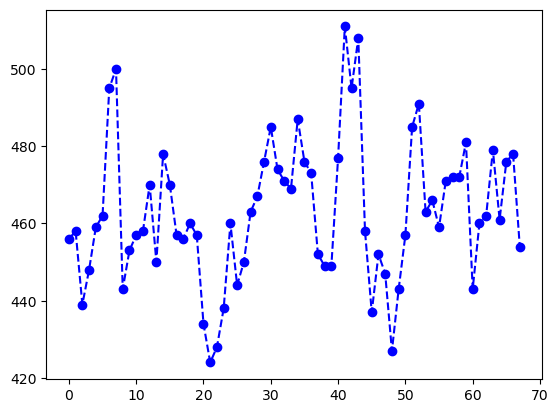

In [3]:
# Plot the data first
plt.plot(data_stack['value'], color='b', linestyle='--', marker='o')
plt.show()

> Perform the runs test to check if the data are random. Use the `runstest_1samp` function from the `statsmodels` package.

In [4]:
# Import the necessary libraries for the runs test
from statsmodels.sandbox.stats.runs import runstest_1samp

_, pval_runs = runstest_1samp(data_stack['value'], correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs))


Runs test p-value = 0.000


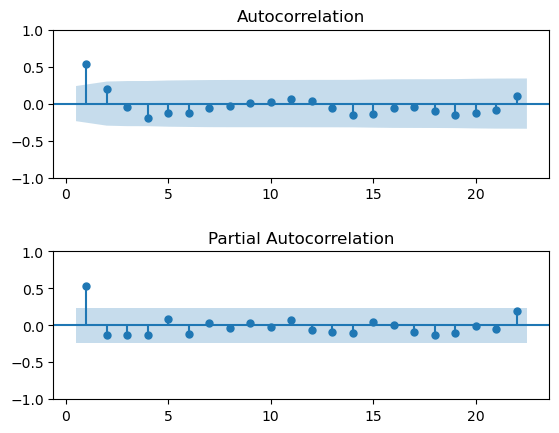

In [5]:
# Plot the acf and pacf using the statsmodels library
import statsmodels.graphics.tsaplots as sgt

fig, ax = plt.subplots(2, 1)
sgt.plot_acf(data_stack['value'], lags = int(len(data_stack)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(data_stack['value'], lags = int(len(data_stack)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

## Point 2

Fit a suitable regression model that captures the temporal correlation of observations.

> Let's try to fit an AR(1) model. 

In [6]:
# Add a column with the lagged temperature to use as regressor
data_stack['lag1'] = data_stack['value'].shift(1)

# Fit the linear regression model
import statsmodels.api as sm

x = data_stack['lag1'][1:]
x = sm.add_constant(x) # this command is used to consider a constant to the model, is equivalent to create and add a column of ones
y = data_stack['value'][1:]
model = sm.OLS(y, x).fit()
qda.summary(model)

REGRESSION EQUATION
-------------------
value =  + 213.531 const + 0.539 lag1

COEFFICIENTS
------------
 Term     Coef  SE Coef  T-Value    P-Value
const 213.5313  48.4731   4.4052 4.0377e-05
 lag1   0.5388   0.1046   5.1515 2.6037e-06

MODEL SUMMARY
-------------
    S   R-sq  R-sq(adj)
15.77 0.2899      0.279

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS    Adj MS  F-Value    P-Value
Regression  1.0  6599.8759 6599.8759  26.5383 2.6037e-06
     const  1.0  4825.9632 4825.9632  19.4054 4.0377e-05
      lag1  1.0  6599.8759 6599.8759  26.5383 2.6037e-06
     Error 65.0 16164.9898  248.6922      NaN        NaN
     Total 66.0 22764.8657       NaN      NaN        NaN


> Check the residuals

Shapiro-Wilk test p-value on the residuals = 0.790


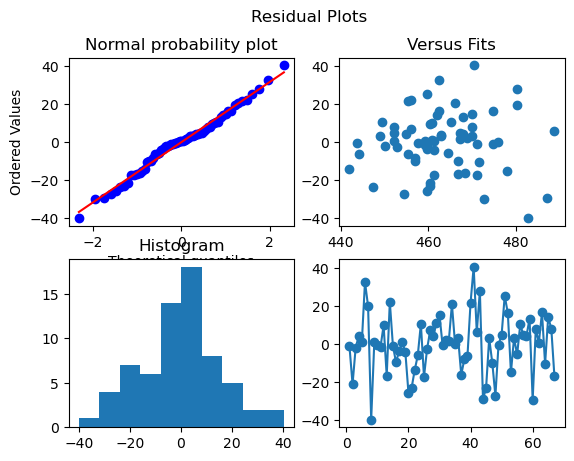

In [7]:
# Plot the residuals and test for normality
fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')
stats.probplot(model.resid, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Normal probability plot')
axs[0,1].scatter(model.fittedvalues, model.resid)
axs[0,1].set_title('Versus Fits')
axs[1,0].hist(model.resid)
axs[1,0].set_title('Histogram')
axs[1,1].plot(np.arange(1, len(model.resid)+1), model.resid, 'o-')
_, pval_SW_res = stats.shapiro(model.resid)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

In [8]:
_, pval_runs_resid = runstest_1samp(model.resid, correction=False)
print('Runs test p-value = {:.3f}'.format(pval_runs_resid))

Runs test p-value = 0.412


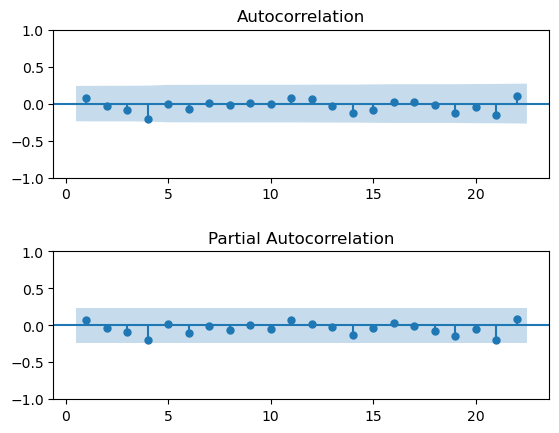

In [9]:
# Check the autocorrelation of the residuals
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(model.resid, lags = int(len(data_stack)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(model.resid, lags = int(len(data_stack)/3), zero=False, ax=ax[1], method = 'ywm')
plt.show()

## Point 3

Design both SCC and FVC charts for process data.

> Let's make a SCC. 

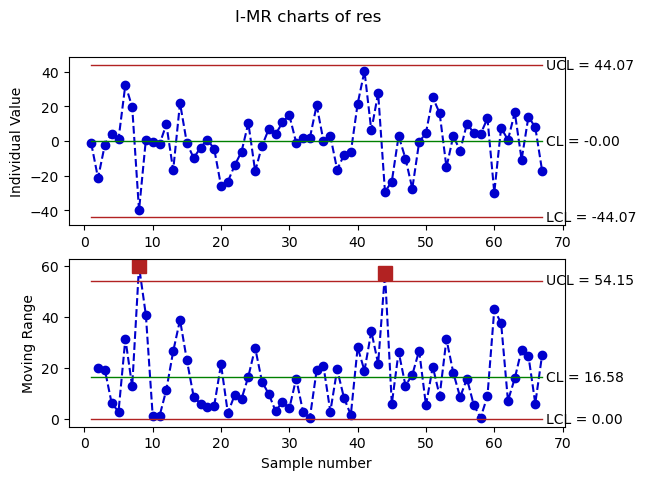

In [10]:
df_SCC = pd.DataFrame({'res': model.resid})
df_SCC = qda.ControlCharts.IMR(df_SCC, 'res')

> Are the OOCs due to non-normality of the MR statistic?
>
> Try to design the MR chart with probabilistic limits, i.e., transform the MR statistic. 

Shapiro-Wilk test p-value = 0.000


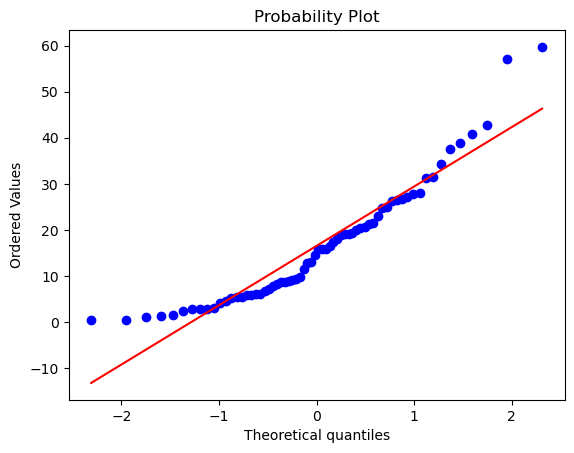

In [11]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(df_SCC['MR'].iloc[1:])
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(df_SCC['MR'].iloc[1:], dist="norm", plot=plt)
plt.show()

Lambda = 0.355


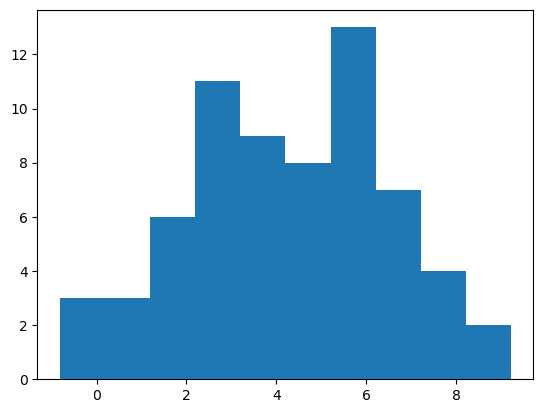

In [12]:
# Box-Cox transformation and return the transformed data
[data_BC, lmbda] = stats.boxcox(df_SCC['MR'].iloc[1:])

print('Lambda = %.3f' % lmbda)

# Plot a histogram of the transformed data
plt.hist(data_BC)
plt.show()

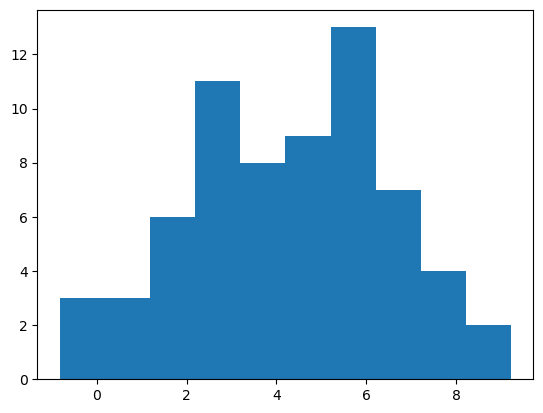

In [13]:
# Use lambda = 0 for Box-Cox transformation and return the transformed data
df_SCC['MR_boxcox'] = stats.boxcox(df_SCC['MR'], lmbda=0.355)

# Plot a histogram of the transformed data
plt.hist(df_SCC['MR_boxcox'])
plt.show()

Shapiro-Wilk test p-value = 0.697


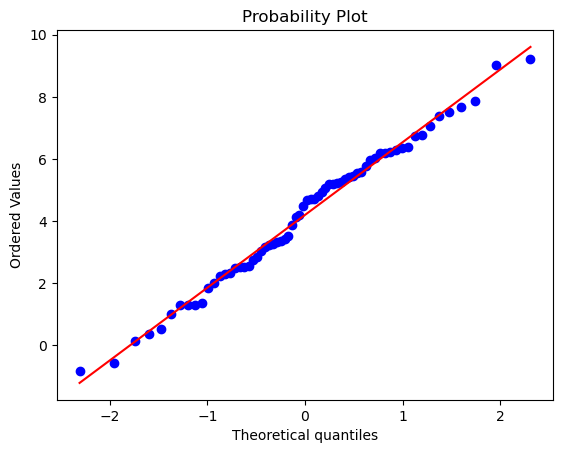

In [14]:
# Perform the Shapiro-Wilk test
_, pval_SW = stats.shapiro(df_SCC['MR_boxcox'].iloc[1:])
print('Shapiro-Wilk test p-value = %.3f' % pval_SW)

# Plot the qqplot
stats.probplot(df_SCC['MR_boxcox'].iloc[1:], dist="norm", plot=plt)
plt.show()

> After the transformation we can design an I chart on the transformed data. Select the I_CL, I_UCL, I_LCL to build the new chart for MR.

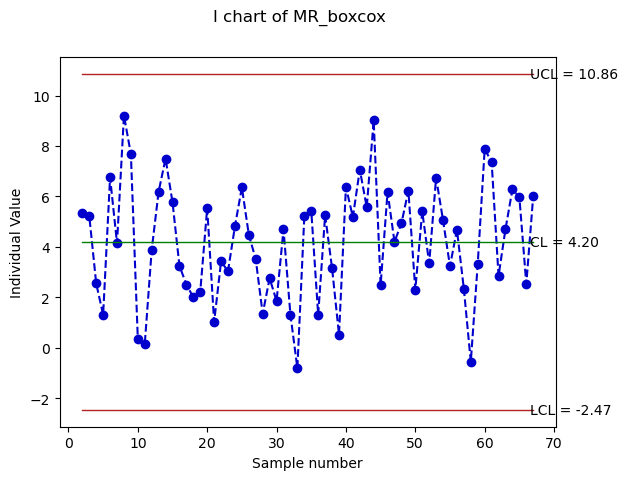

In [20]:
df_MR_boxcox = df_SCC[['MR_boxcox']].iloc[1:]
df_MR_boxcox = qda.ControlCharts.IMR(df_MR_boxcox, 'MR_boxcox', plotit=False)

# Plot the I chart
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I chart of MR_boxcox'))
ax.plot(df_MR_boxcox['MR_boxcox'], color='mediumblue', linestyle='--', marker='o')
ax.plot(df_MR_boxcox['I_UCL'], color='firebrick', linewidth=1)
ax.plot(df_MR_boxcox['I_CL'], color='g', linewidth=1)
ax.plot(df_MR_boxcox['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(df_MR_boxcox)+.5, df_MR_boxcox['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(df_MR_boxcox['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(df_MR_boxcox)+.5, df_MR_boxcox['I_CL'].iloc[0], 'CL = {:.2f}'.format(df_MR_boxcox['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(df_MR_boxcox)+.5, df_MR_boxcox['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(df_MR_boxcox['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(df_MR_boxcox['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()


> Let's plot the fitted value chart (FVC)

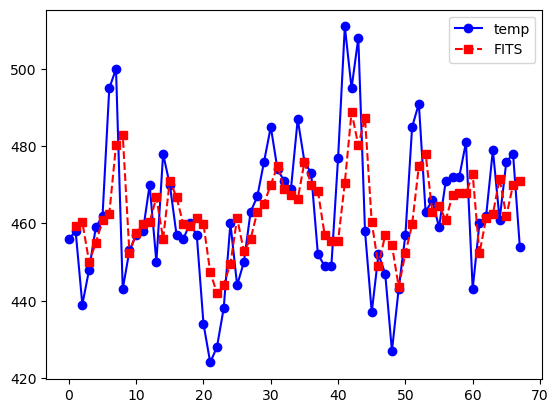

In [21]:
plt.plot(data_stack['value'], color='b', linestyle='-', marker='o', label='temp')
plt.plot(model.fittedvalues, color='r', linestyle='--', marker='s', label='FITS')
plt.legend()
plt.show()

## Point 4

If data within the sample are not random, the Xbar chart based on all the data is different from the Xbar chart designed by using the means as individual observations. Explain why (for sake of simplicity, discuss the case with n=2).

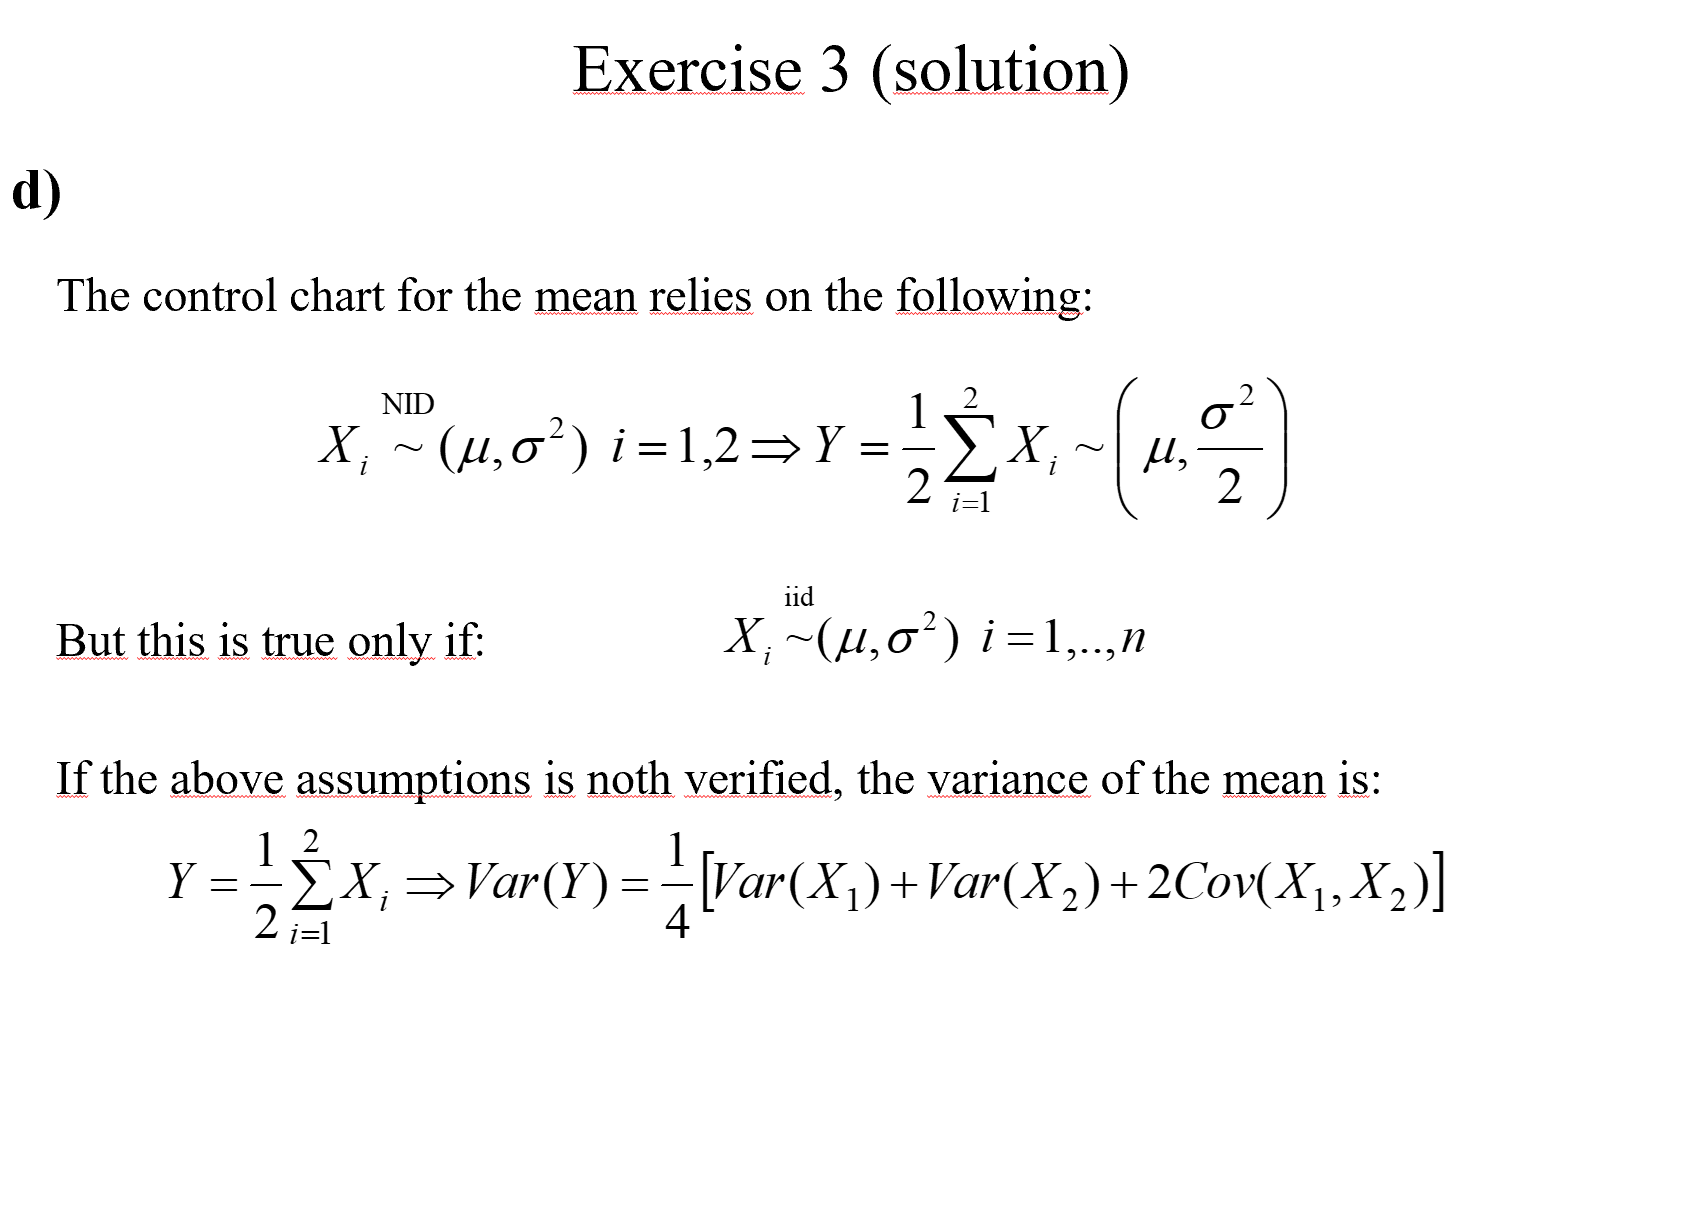